In [2]:
%run /eos/project/l/liu/Toolbox/myToolbox.py
print '---'
%run /eos/user/e/esenes/PS-analysis-tools/eTools.py
print '---'
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.


Your platform is Linux-3.10.0-693.11.6.el7.x86_64-x86_64-with-redhat-6.9-Carbon
Your folder is /eos/user/e/esenes/Injection_missteering/2017.11.14
Your IP is 172.17.0.24
2018-04-19 13:26:11
---
Version 0.1
Use at your own risk. Please report bugs to eugenio.senes@cern.ch
Fork it at https://gitlab.cern.ch/esenes/PS-analysis-tools
---


In [3]:
sys.path.append('/eos/project/l/liu/Instrumentation/Scripts')
import metaclass

# User inputs

In [4]:
folderPath = '/eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14'

matlabVars = ['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1', # Wirescanner 65
                'PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_65_H_ROT.Acquisition.value.acqTimeInCycleSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.projDataSet1', # Wirescanner 85
                'PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1',
                'PR_BWS_85_V_ROT.Acquisition.value.acqTimeInCycleSet1',
                'logical_PI_KFA45.K.value', # Kicker k parameter value (mrad)
                'PI_KFA45.AQN1.value',
                'PI_KFA45.CCV.value', 
                'PR_BPM.AcquisitionOrbit.value.position', # BPMs
                'PR_BPM.AcquisitionTrajectoryBBB.value.position',
                'PR_BCT_ST.Samples.value.samples']



In [5]:
# let's start with the matlab data
files = sorted(glob.glob(folderPath+'/data_WS_185/2017*.mat'))
print 'Found ' + str(len(files)) + ' data files'
print 'First: ' + files[0]
print 'End: ' + files[-1]

Found 207 data files
First: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/data_WS_185/2017.11.14.16.32.08.929.mat
End: /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/data_WS_185/2017.11.14.18.39.51.951.mat


In [6]:
myDataFrame = myToolbox.fromMatlabToDataFrame(files,matlabVars,verbose=False)

# Data cleanup

In [7]:
myDataFrame = checkDuplicates(myDataFrame) # Drop double acquisitions from matlab
myDataFrame = checkBPMData(myDataFrame) # BPMs fault
# manual data drop
myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:58:45.100000'].name) # X wirescanner fault
myDataFrame = myDataFrame.drop(myDataFrame.loc['2017-11-14 17:59:28.300000'].name) # non-phys emittance

No duplicates found
---
BPM data ok
---


# Load the reference kick

In [8]:
# refPath = folderPath+'/refKicker.mat'
# scipy.io.whosmat(refPath)
# rk = scipy.io.loadmat(refPath)['k']

# Import the optics model

In [9]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Booster emittance

In [29]:
emix_norm_PSB = 2.312
emiy_norm_PSB = 2.143

emix_geom_PSB = emix_norm_PSB/(betar*gammar)
emiy_geom_PSB = emiy_norm_PSB/(betar*gammar)

# Find the shift value

Text(0,0.5,u'KFA45 AQN')

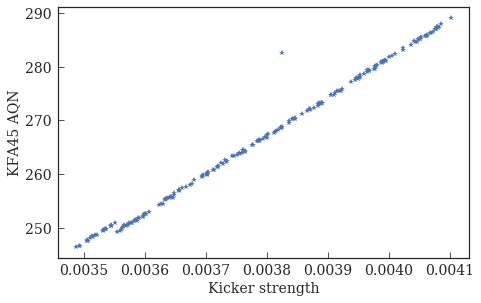

In [11]:
shiftVal=1
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['PI_KFA45.AQN1.value'],'*')
plt.xlabel('Kicker strength')
plt.ylabel('KFA45 AQN')

# Match the tomogram data

In [12]:
# directly copied from one of Guido's analyses
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt(fileName[0:-4] + '/d001.data')
    image=np.loadtxt(fileName[0:-4] + '/image001.data')
    with open(fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2]),
            'cycleStamp':np.int(tomofileheader[1]),                    # cyclestamp in unix time
            'pickupSensitivity':np.double(tomofileheader[97])          # pickup sensitivity
    }

    with open(fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [13]:
# new tomogram analysis
files_tomo=sorted(glob.glob(folderPath+'/tomo_data/*.dat'))

del(files_tomo[159])

tomo_data = pnd.DataFrame()

for f in range(len(files_tomo)):
    try:
        tomo_d = extractProfile(files_tomo[f])
        tomo_d['Filename'] = files_tomo[f]
        if tomo_d is np.nan:
            pass
        else:
            tomo_data=tomo_data.append(tomo_d,ignore_index=True)
    except IOError:
        print '\nIOError\n'

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_003.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_005.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_006.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_052.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_053.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_054.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_055.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_056.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_057.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_103.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_104.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_105.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_106.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_107.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_108.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_154.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_155.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_156.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_157.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_158.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_159.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_206.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_207.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_208.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_209.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_210.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_211.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_257.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_258.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_259.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_260.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_261.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_262.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_308.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_309.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_310.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_311.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_312.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_313.dat
/eos/project/l/liu/Ins

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_359.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_360.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_361.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_362.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_363.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo /eos/project/l/liu/PS/data/2017/MD2586_InjectionEmittanceBlowup/2017.11.14/tomo_data/autosave_364.dat
/eos/project/l/liu/Ins

In [14]:
timeTolerance = 19

# ---------- Vars initialisation
myDataFrame['tomoTimestamp']=np.nan
myDataFrame['tomoDelta']=np.nan
myDataFrame['tomoFilename']=np.str
myDataFrame['deltaP_P_rms']=np.nan
myDataFrame['peakLineDensity']=np.nan
myDataFrame['beta']=np.nan
myDataFrame['gamma']=np.nan
myDataFrame['deltaP_P']=[np.empty(0,dtype=float)]*len(myDataFrame)
myDataFrame['momentumProfile']=[np.empty(0,dtype=float)]*len(myDataFrame)


succ_count = 0
last_match = 0
# loop over the tomo_timestamps
for k in range(len(tomo_data)):
    tomo_local_cs = tomo_data['cycleStamp'].values[k]
    t = myToolbox.unixtime2datetime(tomo_local_cs)
    tomo_fname = tomo_data['Filename'].iloc[k]
    tomo_dpprms = tomo_data['deltaP_P_RMS'].iloc[k]
#     tomo_pkldens = tomo_data['peakLineDensity'].iloc[k]
    betar = tomo_data['beta'].iloc[k]
    gammar = tomo_data['gamma'].iloc[k]
    dpp_profil = tomo_data['deltaP_P'].iloc[k]
    p_profil = tomo_data['myProfile'].iloc[k]    


    # loop over the matlab data
    for x in range(len(myDataFrame)):
        c = myToolbox.unixtime2utcdatetime(myDataFrame['cycleStamp'].values[x]*1e-9)
        d = t-c
        d = d.total_seconds()

        if np.abs(d) <= timeTolerance and x > last_match: #avoid match the same tomogram to more matlab acquisition unintentionally
            myDataFrame['tomoTimestamp'].iloc[x] = tomo_local_cs
            myDataFrame['tomoFilename'].iloc[x] = tomo_fname
            myDataFrame['tomoDelta'].iloc[x] = d
            myDataFrame['deltaP_P_rms'].iloc[x]= tomo_dpprms
#             myDataFrame['peakLineDensity'].iloc[x]= tomo_pkldens
            myDataFrame['beta'].iloc[x]= betar
            myDataFrame['gamma'].iloc[x]= gammar
            myDataFrame['deltaP_P'].iloc[x]= dpp_profil
            myDataFrame['momentumProfile'].iloc[x]= p_profil


            succ_count += 1 #dummy counter
            
print str(succ_count) +"/"+ str(len(tomo_data)) +" are within the timeTolerance"
print 'length of dataframe is: '+ str(len(myDataFrame)) 

/cvmfs/sft.cern.ch/lcg/views/LCG_93/x86_64-slc6-gcc62-opt/lib/python2.7/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


204/380 are within the timeTolerance
length of dataframe is: 205


In [15]:
# discard the elements without tomogram
discFlag = np.isnan(myDataFrame['tomoDelta'].values)
myDataFrame = myDataFrame.drop(myDataFrame.loc[discFlag].index)

# Save the imported data

In [16]:
myDataFrame.to_pickle('imported_data.pkl')

In [17]:
# myDataFrame=pnd.red_pickle('imported_data.pkl')

# Intensity

In [16]:
myDataFrame['Intensity'] = myDataFrame['PR_BCT_ST.Samples.value.samples']
myDataFrame['Losses'] = myDataFrame['Intensity'].apply(lambda x: 1-x[:][100]/np.max(x) )

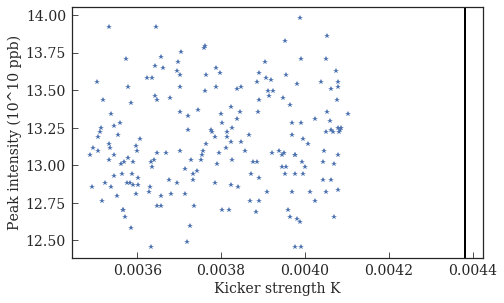

In [17]:
plt.plot(myDataFrame['logical_PI_KFA45.K.value'],myDataFrame['Intensity'].apply(lambda x: np.max(x)),'*')
plt.xlabel('Kicker strength K')
plt.ylabel('Peak intensity (10^10 ppb)')
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

Text(0,0.5,u'Losses')

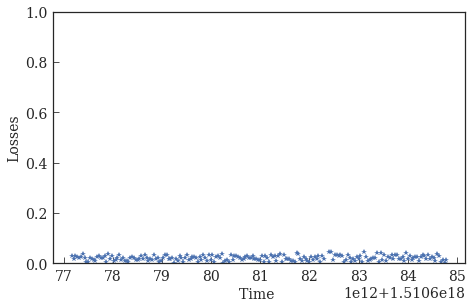

In [18]:
plt.plot(myDataFrame['Losses'],'*')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1))
plt.xlabel('Time ')
plt.ylabel('Losses')

Text(0.5,1,u'10 shots intensity')

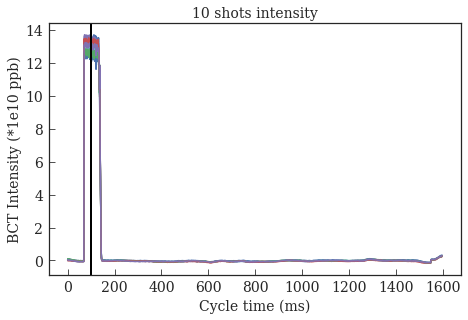

In [19]:
for ll in range(10):
    plt.plot(myDataFrame['Intensity'].values[ll])
    
plt.axvline(x=100, ymin=0, ymax = 8, linewidth=2, color='k')
plt.xlabel('Cycle time (ms)')
plt.ylabel('BCT Intensity (*1e10 ppb)')
plt.title('10 shots intensity')

# Calculate wire scanner emittance
## X plane
### Traditional method

In [20]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS65_position'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS65_position_idx'] = myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS65_data'] = myDataFrame['BWS65_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS65_data'].iloc[r] = np.interp(pos, myDataFrame['BWS65_position'].iloc[r], myDataFrame['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS65_position_idx'].iloc[r]])  
    
#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_x'] = myDataFrame['BWS65_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_x'] = myDataFrame['WS_fit_results_x'].apply(lambda x: x[0][-1])

In [21]:
# Emittance calculation
myDataFrame['WS_emittance_x'] = np.nan
myDataFrame['WS_geom_emittance_x'] = np.nan

for n in range(len(myDataFrame)):
    myDataFrame['WS_emittance_x'].iloc[n] = normalised_emittance('65H',myDataFrame['WS_sigma_x'].values[n],dp=myDataFrame['deltaP_P_rms'].values[n])
    myDataFrame['WS_geom_emittance_x'].iloc[n] = myDataFrame['WS_emittance_x'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

### Dispersive profile deconvolution

In [22]:
# BWS65
betax = 21.77988929
Dx = 3.24577470

betax = 20.11
Dx = 3.2

def deconv_caller(row):
    return myToolbox.computeTransverseEmittance(row['PR_BWS_65_H_ROT.Acquisition.value.projPositionSet1'],
                              row['PR_BWS_65_H_ROT.Acquisition.value.projDataSet1'],
                              row['momentumProfile'],
                              row['deltaP_P'],
                              row['beta']*row['gamma'],
                              betaOptical_m=betax,Dispersion_m=Dx)

myDataFrame['Deconvolution_result'] = myDataFrame.apply(deconv_caller,axis=1)



for k in myDataFrame.index:  
    myDataFrame.loc[k,'Emittance_x_deconv'] = myDataFrame.loc[k,('Deconvolution_result')]['emittance_um']


## Y plane

In [23]:
# Wirescanner sigma
#position data cleanup (sort, get unique values and the idxes) and conversion to mm
myDataFrame['BWS85_position'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[0]*1e-3)
myDataFrame['BWS85_position_idx'] = myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projPositionSet1'].apply(lambda x: np.unique(x, return_index=True)[1])

#instantiate an array object for the result in the frame
myDataFrame['BWS85_data'] = myDataFrame['BWS85_position_idx'].apply(lambda x: np.empty(len(x)))
pos = np.arange(-50, 50, 0.05)

row, col = myDataFrame.shape

for r in xrange(row):
    myDataFrame['BWS85_data'].iloc[r] = np.interp(pos, myDataFrame['BWS85_position'].iloc[r], myDataFrame['PR_BWS_85_V_ROT.Acquisition.value.projDataSet1'].iloc[r][myDataFrame['BWS85_position_idx'].iloc[r]])  

#do the fit and get the sigma in mm
myDataFrame['WS_fit_results_y'] = myDataFrame['BWS85_data'].apply(lambda x: myToolbox.makeGaussianFit_5_parameters(pos,x))
myDataFrame['WS_sigma_y'] = myDataFrame['WS_fit_results_y'].apply(lambda x: x[0][-1])

In [24]:
# Emittance calculation
myDataFrame['WS_emittance_y'] = myDataFrame['WS_sigma_y'].apply(lambda x: normalised_emittance('85V',x))

myDataFrame['WS_geom_emittance_y'] = np.nan
for n in range(len(myDataFrame)):
    myDataFrame['WS_geom_emittance_y'].iloc[n] = myDataFrame['WS_emittance_y'].iloc[n]/(myDataFrame['beta'].iloc[n]*myDataFrame['gamma'].iloc[n])

## Emittance plot

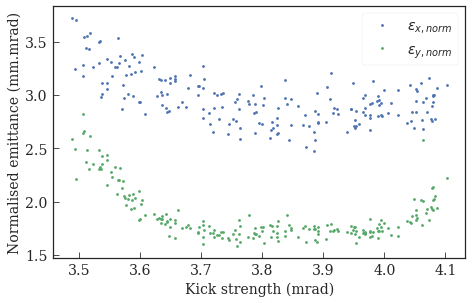

In [25]:
fig, ax = plt.subplots(1)

ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_x'],'.',label='$\epsilon_{x, norm}$')
plt.xlabel('Kick strength (mrad)')
plt.ylabel('Normalised emittance (mm.mrad)')
# plt.axvline(x=rk, ymin=0, ymax = 8, linewidth=2, color='k')
# set axis to get rid of some bad shots
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y'],'.',label='$\epsilon_{y, norm}$')

plt.legend(frameon=True)

fig.savefig('BCMS_under_coupling_emi_xy.eps', format='eps')

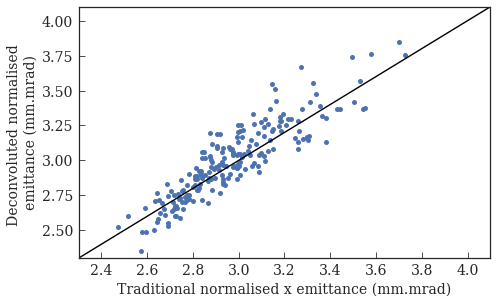

In [26]:
fig2, ax2 = plt.subplots(1)
ax2.plot(myDataFrame['WS_emittance_x'],myDataFrame['Emittance_x_deconv'],'.',markersize=10)
plt.xlabel('Traditional normalised x emittance (mm.mrad)')
plt.ylabel('Deconvoluted normalised \nemittance (mm.mrad)')

ax2.plot([.5,10.],[.5,10.],'-k')
x1,x2,y1,y2 = plt.axis()
plt.axis((2.3,4.1,2.3,4.1))

fig2.savefig('BCMS_under_coupling_Wemi_vs_deconv.eps', format='eps')

In [27]:
# get KFA45 optics parameters
optics_names = optics.NAME

for k in range(len(optics_names)):
    if optics_names[k].find('PI.KFA45') != -1:
        print optics_names[k]
        kicker_name = optics_names[k]
        kicker_idx = k
        kicker_betax = optics.BETA11[k]
        kicker_alphax = optics.ALFA11[k]

PI.KFA45


Model function: a(x - b)^2 + c
Fit params: a=1.8535435157 b= 0.0038822380868 c= 1.23314914529e-06
Expected a=11.263213795
PSB geom emix=1.01818619496


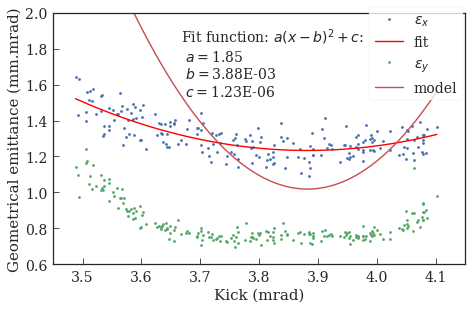

In [30]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal)[1:]
ydata = 1e-6*myDataFrame['WS_geom_emittance_x'].values[1:]

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('Kick (mrad)',fontsize=15)
plt.ylabel('Geometrical emittance (mm.mrad)',fontsize=15)

ax.text(0.31, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.2f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


ax.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['WS_emittance_y']/2.26936518558,'.',label='$\epsilon_y$')


plt.legend(frameon=True)

print 'Expected a='+str(kicker_betax/2)

# ideal curve with PSB emittance
print 'PSB geom emix='+str(emix_geom_PSB)

ax.plot(xfit*1e3, 1e6*f_to_fit(xfit,kicker_betax/2.,p[1],emix_geom_PSB*1e-6),'-',label='model') #factors are to adjust units in the plot

plt.legend(bbox_to_anchor=(0.75,1.05),loc=2,frameon=True)


x1,x2,y1,y2 = plt.axis()
plt.axis((3.45,4.15,.6,2.))

fig.savefig('emi_xy_fitC185.eps', format='eps',dpi=1000)

# BPMs

In [31]:
# BPMs
#add field for the first two turns and splitting x and y pickups
myDataFrame['BPMx_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,0])
myDataFrame['BPMy_turn1'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,0])
myDataFrame['BPMx_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['BPMy_turn2'] = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: x[-43:,1])
# #turn to millimiters and cast in float
myDataFrame['BPMx_turn1'] = myDataFrame['BPMx_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn1'] = myDataFrame['BPMy_turn1'].apply(lambda x: x/10.)
myDataFrame['BPMx_turn2'] = myDataFrame['BPMx_turn2'].apply(lambda x: x/10.)
myDataFrame['BPMy_turn2'] = myDataFrame['BPMy_turn2'].apply(lambda x: x/10.)
# #add orbit
myDataFrame['Orbit_x'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[0:43,1])
myDataFrame['Orbit_y'] = myDataFrame['PR_BPM.AcquisitionOrbit.value.position'].apply(lambda x: x[-43:,1])
myDataFrame['Orbit_x'] = myDataFrame['Orbit_x'].apply(lambda x: x/10.)
myDataFrame['Orbit_y'] = myDataFrame['Orbit_y'].apply(lambda x: x/10.)

In [32]:
# get the optics functions from the model
optics = metaclass.twiss('/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23.outx')

Problem parsing: @ ORBIT_-CT        %le   -0.00000000

Going to be parsed as string
Problem persits, let's ignore it!


# Calculate injection oscillation from the BPM

## 1. Look at one BPM and calculate the oscillation over the first 50 turns

In [33]:
# get the beta at the BPMs position
optics_names = optics.NAME
BPM_name = []
BPM_idx = []
BPM_betax = []
BPM_alphax = []

for k in range(len(optics_names)):
    if optics_names[k].find('PR.BPM') != -1:
#        print optics_names[k]
        BPM_name.append(optics_names[k])
        BPM_idx.append(k)
        BPM_betax.append(optics.BETA11[k])   
        BPM_alphax.append(optics.ALFA11[k])

# for some reason the last bpm is the 00, place it back at the beginning
BPM_name = [BPM_name[-1]] + BPM_name[:-1]
BPM_idx = [BPM_idx[-1]] + BPM_idx[:-1]
BPM_betax = [BPM_betax[-1]] + BPM_betax[:-1]
BPM_alphax = [BPM_alphax[-1]] + BPM_alphax[:-1]

In [34]:
# loop over all the BPM

# fit an harmonic function through the oscillations and extrapolate the amplitude. 
# possible tunes (non integer part) have been restricted to be between .20 and .25 --> 2pi/5 and pi/2

from scipy.optimize import curve_fit
def f_to_fit(x, a, b, c, d):
    return a*np.sin(b*x + c) + d

xdata = np.linspace(0,30,30)
osc_amplitude = np.empty([len(myDataFrame),len(BPM_name)],dtype=float); osc_amplitude[:]=np.nan

# fit boundaries 
bounds=([-np.inf, 1.*pi/5, -pi, -np.inf],[np.inf,pi/2.,pi,np.inf])
# statistical check
chi2 = np.empty([len(myDataFrame),len(BPM_name)],dtype=float)

for m in range(len(BPM_name)):

    for k in range(len(myDataFrame)):
        ydata = myDataFrame['PR_BPM.AcquisitionTrajectoryBBB.value.position'].apply(lambda x: 0.1*x[m,0:30]).values[k]
        # starting values
        p0 = ([2*signalRMS(ydata), 0.45*pi, pi/2, np.mean(ydata)])

        try:
            p, cov = curve_fit(f_to_fit,xdata,ydata,bounds=bounds,p0=p0)
            osc_amplitude[k,m] = np.abs(p[0])

            yfit = f_to_fit(xdata, *p)
            chi2[k,m] = np.sum((yfit - ydata)**2)/len(yfit)

        except RuntimeError:
            print 'fit do not converge on shot '+str(k)
            osc_amplitude[k,m] = np.nan
            chi2[k,m] = np.nan
        
    print BPM_name[m] + ' processed with success '+ str(np.count_nonzero(~np.isnan(osc_amplitude[:,m]))) +'/'+str(len(myDataFrame))+' shots'
            
print 'Done.'

PR.BPM00 processed with success 204/204 shots
PR.BPM03 processed with success 204/204 shots
PR.BPM05 processed with success 204/204 shots
PR.BPM07 processed with success 204/204 shots
PR.BPM10 processed with success 204/204 shots
PR.BPM13 processed with success 204/204 shots
PR.BPM15 processed with success 204/204 shots
PR.BPM17 processed with success 204/204 shots
PR.BPM20 processed with success 204/204 shots
PR.BPM23 processed with success 204/204 shots
PR.BPM25 processed with success 204/204 shots
PR.BPM27 processed with success 204/204 shots
PR.BPM30 processed with success 204/204 shots
PR.BPM33 processed with success 204/204 shots
PR.BPM35 processed with success 204/204 shots
PR.BPM37 processed with success 204/204 shots
PR.BPM40 processed with success 204/204 shots
PR.BPM43 processed with success 204/204 shots
PR.BPM45 processed with success 204/204 shots
PR.BPM47 processed with success 204/204 shots
PR.BPM50 processed with success 204/204 shots
PR.BPM53 processed with success 20

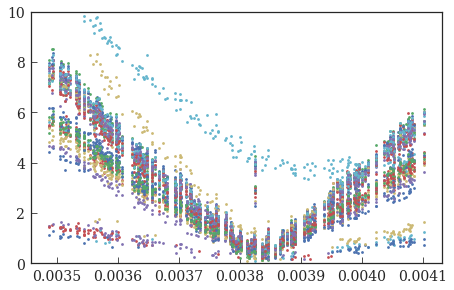

In [35]:
# sanity check 
for k in range(34):
    plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,k],'.')
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0,10))

Beta_x at PR.BPM53: 22.22678114


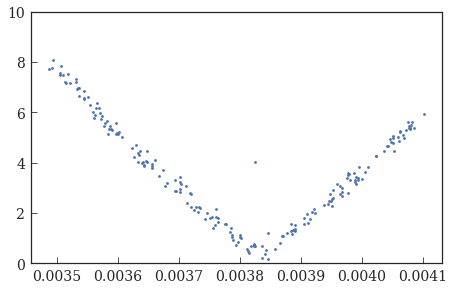

In [36]:
# manual inspection
bpm_n = 21
plt.plot(myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),osc_amplitude[:,bpm_n],'.')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,10))
print 'Beta_x at '+BPM_name[bpm_n]+': '+str(BPM_betax[bpm_n])

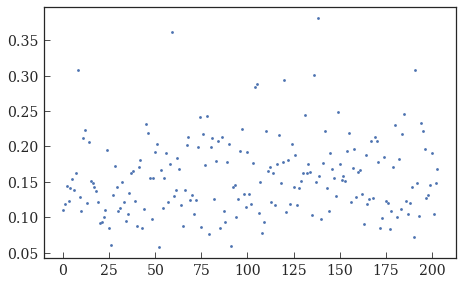

In [37]:
plt.plot(chi2[:,bpm_n],'.')

Text(0,0.5,u'Shot number')

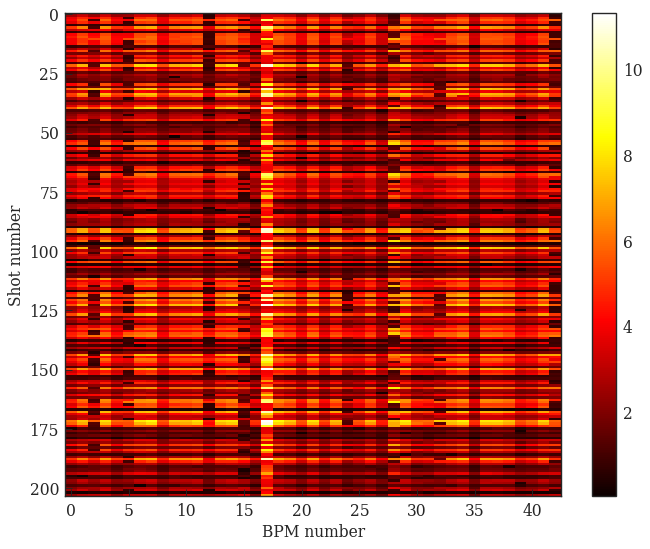

In [38]:
fig=plt.figure(figsize=(10, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(osc_amplitude[:,:],
           cmap='hot',
           aspect='auto'
          )
plt.colorbar()
plt.xlabel('BPM number')
plt.ylabel('Shot number')

## 2. RMS orbit deviation 1st-2nd turn and 1st turn-1ms orbit

### calculate the RMS orbit deviation
Use difference between the first and second turn to evaluate the orbit deviation from the reference orbit, where


$$\Delta x_\text{rms} =  \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn2} - x_\text{turn1})^2 }$$


excluding the BPM in the bump, that would dominate the estimator.

Same for the deviation from the orbit 

$$\Delta x_\text{rms, orbit} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (x_\text{turn1} - x_\text{average_orbit_1ms})^2 }$$

In [39]:
# X plane
mySeries1 = myDataFrame['BPMx_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMx_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_x'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaX_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
myDataFrame['OrbitX_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

# Y plane
mySeries1 = myDataFrame['BPMy_turn1'].apply(lambda x: np.delete(x,17))
mySeries2 = myDataFrame['BPMy_turn2'].apply(lambda x: np.delete(x,17))
myOrbit = myDataFrame['Orbit_y'].apply(lambda x: np.delete(x,17))

myDataFrame['deltaY_2turns'] = signalRMSDifference(mySeries1,mySeries2,42) # BPM43 excluded
myDataFrame['OrbitY_dev_RMS'] = signalRMSDifference(mySeries1,myOrbit,42) # BPM43 excluded

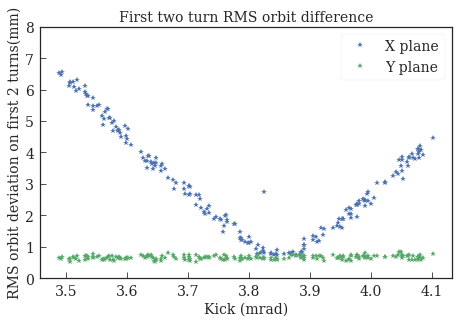

In [40]:
plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaX_2turns'].values,'*',label='X plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation on first 2 turns(mm)')
plt.title('First two turn RMS orbit difference')

plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['deltaY_2turns'].values,'*',label='Y plane')



plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,8))
plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

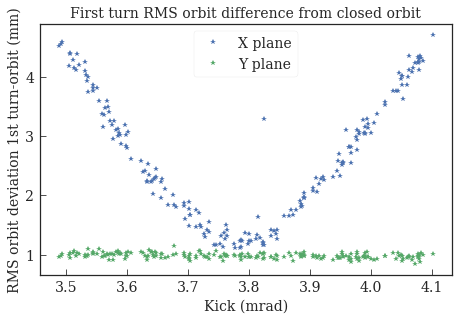

In [41]:
plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitX_dev_RMS'].values,'*',label='X plane')

plt.xlabel('Kick (mrad)')
plt.ylabel('RMS orbit deviation 1st turn-orbit (mm)')
plt.title('First turn RMS orbit difference from closed orbit')

plt.plot(1e3*myDataFrame['logical_PI_KFA45.K.value'].shift(shiftVal),myDataFrame['OrbitY_dev_RMS'].values,'*',label='Y plane')


plt.legend(frameon=True)
x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,8))
# plt.axvline(x=0.004381000000000, ymin=0, ymax = 8, linewidth=2, color='k')

# Methods comparison

## 1) Single BPM method

In [42]:
bpm_n1 = 25
osc1 = osc_amplitude[:,bpm_n1]
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))
bpm_n2 = 21
osc2 = osc_amplitude[:,bpm_n2]
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))

At PR.BPM60 betax=12.15900765 alphax=0.04780143
Expected value for the fit a=0.04121573921
At PR.BPM53 betax=22.22678114 alphax=0.00066337
Expected value for the fit a=0.0224953949418


Model function: a(x - b)^2 + c
Fit params: a=0.00903690054866 c= 1.22980254445e-06
 
At PR.BPM60 betax=12.15900765 alphax=0.04780143
Expected value for the fit a=0.04121573921


(-0.14981616165392503, 5.914454631319745, 1, 2.0)

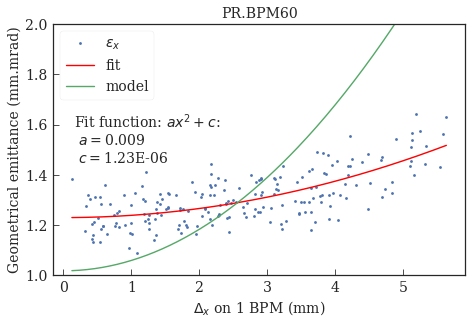

In [47]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x)**2 + c

xdata = 1e-3*osc1
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


plt.xlabel('$\Delta_x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n1])

ax.text(0.05, 0.65, 'Fit function: $a x^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n1]+' betax='+str(BPM_betax[bpm_n1])+' alphax='+str(BPM_alphax[bpm_n1])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1]))


ax.plot(xfit*1e3, 1e6*f_to_fit(xfit,((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1])),emix_geom_PSB*1e-6),'-',label='model') #factors are to adjust units in the plot

plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,2.))

Model function: a x^2 + c
Fit params: a=0.00444038804147 c= 1.23147081761e-06
 
At PR.BPM53 betax=22.22678114 alphax=0.00066337
Expected value for the fit a=0.0224953949418
Theoretically a=(1+alpha^2)/2beta


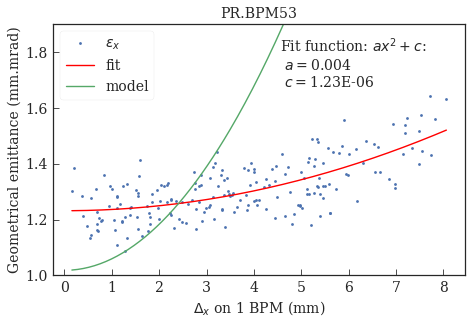

In [52]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a*(x)**2 + c

xdata = 1e-3*osc2
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a x^2 + c'
print 'Fit params: a=' + str(p[0]) +  ' c= '+ str(p[1])


plt.xlabel('$\Delta_x$ on 1 BPM (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title(BPM_name[bpm_n2])

ax.text(0.55, 0.95, 'Fit function: $a x^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'At '+BPM_name[bpm_n2]+' betax='+str(BPM_betax[bpm_n2])+' alphax='+str(BPM_alphax[bpm_n2])
print 'Expected value for the fit a='+str((1+BPM_alphax[bpm_n2]**2)/(2*BPM_betax[bpm_n2]))
print 'Theoretically a=(1+alpha^2)/2beta'

ax.plot(xfit*1e3, 1e6*f_to_fit(xfit,((1+BPM_alphax[bpm_n1]**2)/(2*BPM_betax[bpm_n1])),emix_geom_PSB*1e-6),'-',label='model') #factors are to adjust units in the plot

plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,1.9))

fig.savefig('single_BPM185.eps', format='eps')

## 2) All BPM - single turn method

Model function: a x^2 + c
Fit params: a=0.00679289601688 c= 1.22861856979e-06
 
Expected value for the fit a=0.03125


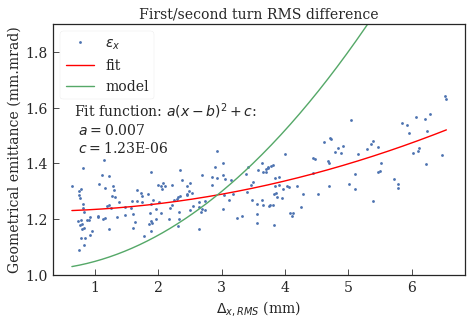

In [57]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, c):
    return a * x**2 + c

xdata = 1e-3*myDataFrame['deltaX_2turns']
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a x^2 + c'
print 'Fit params: a=' + str(p[0]) + ' c= '+ str(p[1])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First/second turn RMS difference')

ax.text(0.05, 0.7, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $c=$%.2E'%(p[0],p[1]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'Expected value for the fit a='+str(1./(2.*16.))


ax.plot(xfit*1e3, 1e6*f_to_fit(xfit,(1./(2.*16.)),emix_geom_PSB*1e-6),'-',label='model') #factors are to adjust units in the plot

plt.legend(frameon=True)


x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,1,1.9))

fig.savefig('all_BPM185.eps', format='eps')

Model function: a(x - b)^2 + c
Fit params: a=0.00165681544881 b= -0.0109464973147 c= 1.00023252727e-06
 
Expected value for the fit a=0.03125


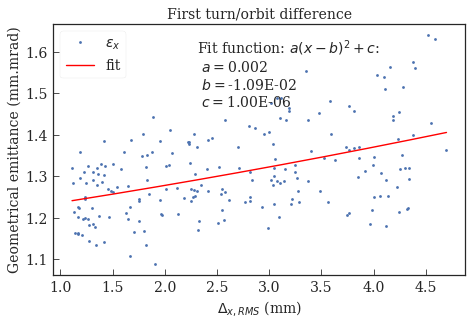

In [58]:
from scipy.optimize import curve_fit

def f_to_fit(x, a, b, c):
    return a*(x - b)**2 + c

xdata = 1e-3*myDataFrame['OrbitX_dev_RMS']
ydata = 1e-6*myDataFrame['WS_geom_emittance_x']

fig, ax = plt.subplots(1)
ax.plot(1e3*xdata, 1e6*ydata,'.',label='$\epsilon_x$') #factors are to adjust units in the plot

p, cov = curve_fit(f_to_fit,xdata,ydata)

xfit = np.linspace(np.min(xdata),np.max(xdata),200)
ax.plot(1e3*xfit, 1e6*f_to_fit(xfit, *p), 'r-', label='fit') #factors are to adjust units in the plot

#fit and plot fit
print 'Model function: a(x - b)^2 + c'
print 'Fit params: a=' + str(p[0]) + ' b= ' + str(p[1]) + ' c= '+ str(p[2])


plt.xlabel('$\Delta_{x,RMS}$ (mm)')
plt.ylabel('Geometrical emittance (mm.mrad)')
plt.title('First turn/orbit difference')

ax.text(0.35, 0.95, 'Fit function: $a(x-b)^2+c$:\n $a=$%.3f \n $b=$%.2E \n $c=$%.2E'%(p[0],p[1],p[2]),
        transform=ax.transAxes, fontsize=14,verticalalignment='top')

x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,1.5,4.2))


plt.legend(frameon=True)
print ' '
print 'Expected value for the fit a='+str(1./(2.*16.))

# Laslett tune shift calculation

In [59]:
myDataFrame['peakLineDensity'] = 0.39

In [60]:
# brightness and intensity
myDataFrame['WS_intensity'] = myDataFrame['Intensity'].apply(lambda x: x[80])
myDataFrame['Brightness'] = myDataFrame['WS_intensity']/(0.5*(myDataFrame['WS_emittance_x']+myDataFrame['WS_emittance_y']))

In [61]:
twiss_file_name = '/eos/user/e/esenes/AnalysisTools/Injection7_optics_Qx_0.21_Qy_0.23_cycled_timefalse.outx'

[deltaQx, deltaQy] = laslett_sc_PS(myDataFrame['peakLineDensity'], myDataFrame['deltaP_P_rms'],
              1e-6*myDataFrame['WS_emittance_x'], 1e-6*myDataFrame['WS_emittance_y'],
              1400, twiss_file_name)

myDataFrame['deltaQx'] = deltaQx
myDataFrame['deltaQy'] = deltaQy

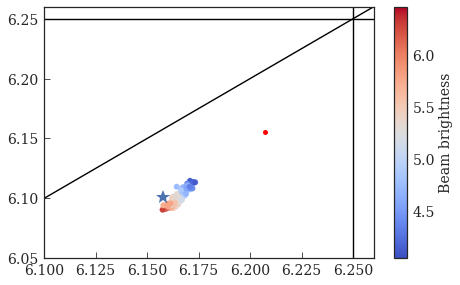

In [62]:
fig, ax = plt.subplots(1)

# working point
Qx = 6.207
Qy = 6.155
plt.plot(Qx,Qy,'r.',markersize=10)

# tune diagram lines
ax.plot([5.8, 6.3],[5.8, 6.3],'k')
ax.plot([6, 6],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6, 6],'k')
ax.plot([6.25, 6.25],[5.8, 6.3],'k')
ax.plot([5.8, 6.3],[6.25, 6.25],'k')
# options
plt.xlim([6.1, 6.26])
plt.ylim([6.05, 6.26])
# tune shifts


p1 = ax.scatter(Qx+myDataFrame['deltaQx'], Qy+myDataFrame['deltaQy'], c=myDataFrame['Brightness'], cmap=plt.cm.coolwarm)
clb = fig.colorbar(p1)
clb.set_label('Beam brightness')

# PSB point
[deltaQxPSB, deltaQyPSB] = laslett_sc_PS(0.39, 0.5e-3,
              1e-6*2.312, 1e-6*2.143,
              1400, twiss_file_name)
plt.plot(Qx+deltaQxPSB,Qy+deltaQyPSB,'*',markersize=15)


plt.show()

fig.savefig('BCMS_under_coupling_footprint.eps', format='eps')

In [ ]:
--> fix the peak line density in the tomogram function
--> Turn your library into a class, define the methods as static methods and change all the callers as eTools.functionNaME()
--> implementa il local indexing instaed of the iloc in the dataframe